# The thinking behind this code

I'd just like to be able to visualize all of the EVE lines data. My main focus has been on the MEGS-A data, which spans 2010-2014. MEGS-B spans that but continues to the present date, but with bursted cadence. I don't have the full time range on hand, just the MEGS-A era, so I'll focus on that. 

In [1]:
# Standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
from scipy.io.idl import readsav
from skimage.measure import block_reduce

# Custom modules
from jpm_time_conversions import *
from jpm_logger import JpmLogger
%matplotlib inline
plt.style.use('jpm-transparent-dark')

/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## First things first: load in the EVE data and get it into a pandas dataframe.

In [2]:
eve_readsav = readsav('/Users/jmason86/Dropbox/Research/Data/EVE/eve_lines_2010121-2014146 MEGS-A Mission Bare Bones.sav')

In [3]:
irradiance = eve_readsav['irradiance'].byteswap().newbyteorder()  # pandas doesn't like big endian
irradiance[irradiance == -1] = np.nan
logt = eve_readsav.logt
wavelengths = eve_readsav['wavelength']
wavelengths_str = []
[wavelengths_str.append('{0:1.1f}'.format(wavelength)) for wavelength in wavelengths]
eve_lines_df = pd.DataFrame(irradiance, columns=wavelengths_str)
eve_lines_df.index = pd.to_datetime(eve_readsav.iso.astype(str))
eve_lines_df = eve_lines_df.drop_duplicates()

In [4]:
eve_lines_df.head()

,9.4,13.1,13.3,17.1,17.7,18.0,19.5,20.2,21.1,25.6,...,71.9,72.2,77.0,79.0,83.6,95.0,97.3,97.7,102.6,103.2
2010-05-01 00:00:10,0.000004,0.000002,7.858343e-07,0.000059,0.000037,0.00005,0.000035,0.000027,0.000015,0.00003,...,0.000002,7.251622e-07,0.000012,0.000015,0.000031,0.000011,0.000018,0.000134,0.00008,0.000057
2010-05-01 00:01:10,0.000004,0.000002,8.028433e-07,0.000059,0.000038,0.00005,0.000035,0.000027,0.000015,0.00003,...,0.000002,6.778981e-07,0.000012,0.000015,0.000032,0.000011,0.000018,0.000134,0.00008,0.000057
2010-05-01 00:02:10,0.000004,0.000002,7.927638e-07,0.000059,0.000038,0.00005,0.000034,0.000027,0.000015,0.00003,...,0.000002,6.810881e-07,0.000012,0.000015,0.000031,0.000011,0.000018,0.000135,0.00008,0.000057
2010-05-01 00:03:10,0.000004,0.000002,7.809158e-07,0.000059,0.000037,0.00005,0.000035,0.000027,0.000015,0.00003,...,0.000002,7.634823e-07,0.000012,0.000015,0.000031,0.000011,0.000017,0.000134,0.00008,0.000057
2010-05-01 00:04:10,0.000004,0.000002,7.822941e-07,0.000058,0.000038,0.00005,0.000035,0.000027,0.000015,0.00003,...,0.000002,6.575664e-07,0.000012,0.000015,0.000031,0.000011,0.000018,0.000135,0.00008,0.000057


### Now make another dataframe with the columns sorted by temperature

In [5]:
cols_arr = np.array(eve_lines_df.columns.tolist())
sorted_temperature_indices = np.argsort(logt)
cols_sorted = cols_arr[sorted_temperature_indices].tolist()
eve_lines_temperature_sorted_df = eve_lines_df[cols_sorted]

In [6]:
eve_lines_temperature_sorted_df.head()

,97.3,95.0,53.7,102.6,58.4,71.9,83.6,30.4,25.6,97.7,...,49.9,28.4,33.5,36.1,44.6,9.4,59.2,72.2,56.8,13.3
2010-05-01 00:00:10,0.000018,0.000011,0.000005,0.00008,0.000046,0.000002,0.000031,0.000483,0.00003,0.000134,...,0.000011,0.000024,0.000012,NaN,5.945670e-07,0.000004,7.376746e-07,7.251622e-07,8.752820e-07,7.858343e-07
2010-05-01 00:01:10,0.000018,0.000011,0.000005,0.00008,0.000046,0.000002,0.000032,0.000482,0.00003,0.000134,...,0.000011,0.000024,0.000013,NaN,5.989884e-07,0.000004,7.356533e-07,6.778981e-07,8.571183e-07,8.028433e-07
2010-05-01 00:02:10,0.000018,0.000011,0.000005,0.00008,0.000046,0.000002,0.000031,0.000484,0.00003,0.000135,...,0.000011,0.000024,0.000013,NaN,6.054031e-07,0.000004,7.125714e-07,6.810881e-07,8.610279e-07,7.927638e-07
2010-05-01 00:03:10,0.000017,0.000011,0.000005,0.00008,0.000046,0.000002,0.000031,0.000482,0.00003,0.000134,...,0.000011,0.000024,0.000013,NaN,6.334220e-07,0.000004,7.355283e-07,7.634823e-07,8.675086e-07,7.809158e-07
2010-05-01 00:04:10,0.000018,0.000011,0.000005,0.00008,0.000046,0.000002,0.000031,0.000484,0.00003,0.000135,...,0.000011,0.000024,0.000013,NaN,6.067462e-07,0.000004,7.326703e-07,6.575664e-07,8.608862e-07,7.822941e-07


## Now produce a plot with x = time, y = wavelength, color = irradiance

In [7]:
time = eve_lines_df.index
wavelength = eve_lines_df.columns.astype(float)
intensity = eve_lines_df.values
intensity_norm = np.empty_like(intensity)
for i in range(39):
    intensity_norm[:, i] = intensity[:, i] / np.nanmedian(intensity[:, i])

In [8]:
# Smooth and subsample the data to dramatically decrease plotting time
# Can't see all 2 million points in time on the plot anyway
subsample = 1000
intensity_subsampled = block_reduce(intensity, block_size=(subsample, 1), func=np.nanmax)
intensity_norm_subsampled = block_reduce(intensity_norm, block_size=(subsample, 1), func=np.nanmean)
time_subsampled = time[0:-1:subsample]

/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/skimage/measure/block.py:77: RuntimeWarning: All-NaN slice encountered
  out = func(out, axis=-1)
/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/skimage/measure/block.py:77: RuntimeWarning: Mean of empty slice
  out = func(out, axis=-1)


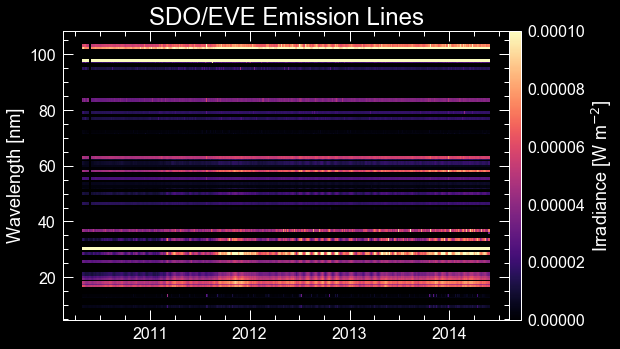

In [24]:
for wave_index in range(39):
    p = plt.scatter(time_subsampled, np.repeat(wavelength[wave_index], len(time_subsampled)), 
                    c=intensity_subsampled[:, wave_index], 
                    cmap=plt.cm.magma, marker='|', s=10, edgecolor='none')
    plt.clim(0, 1e-4)#np.nanmin(intensity_subsampled), np.nanmax(intensity_subsampled))

fig = plt.gcf()
ax = plt.gca()
fmtr = dates.DateFormatter("%Y")
ax.xaxis.set_major_formatter(fmtr)
ax.xaxis.set_major_locator(dates.YearLocator())
plt.ylabel('Wavelength [nm]')
plt.title('SDO/EVE Emission Lines')
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.73])
fig.colorbar(p, label='Irradiance [W m$^{-2}$]', cax=cbar_ax)

## Now produce a plot with x = time, y = wavelength, color = normalized (by median) irradiance

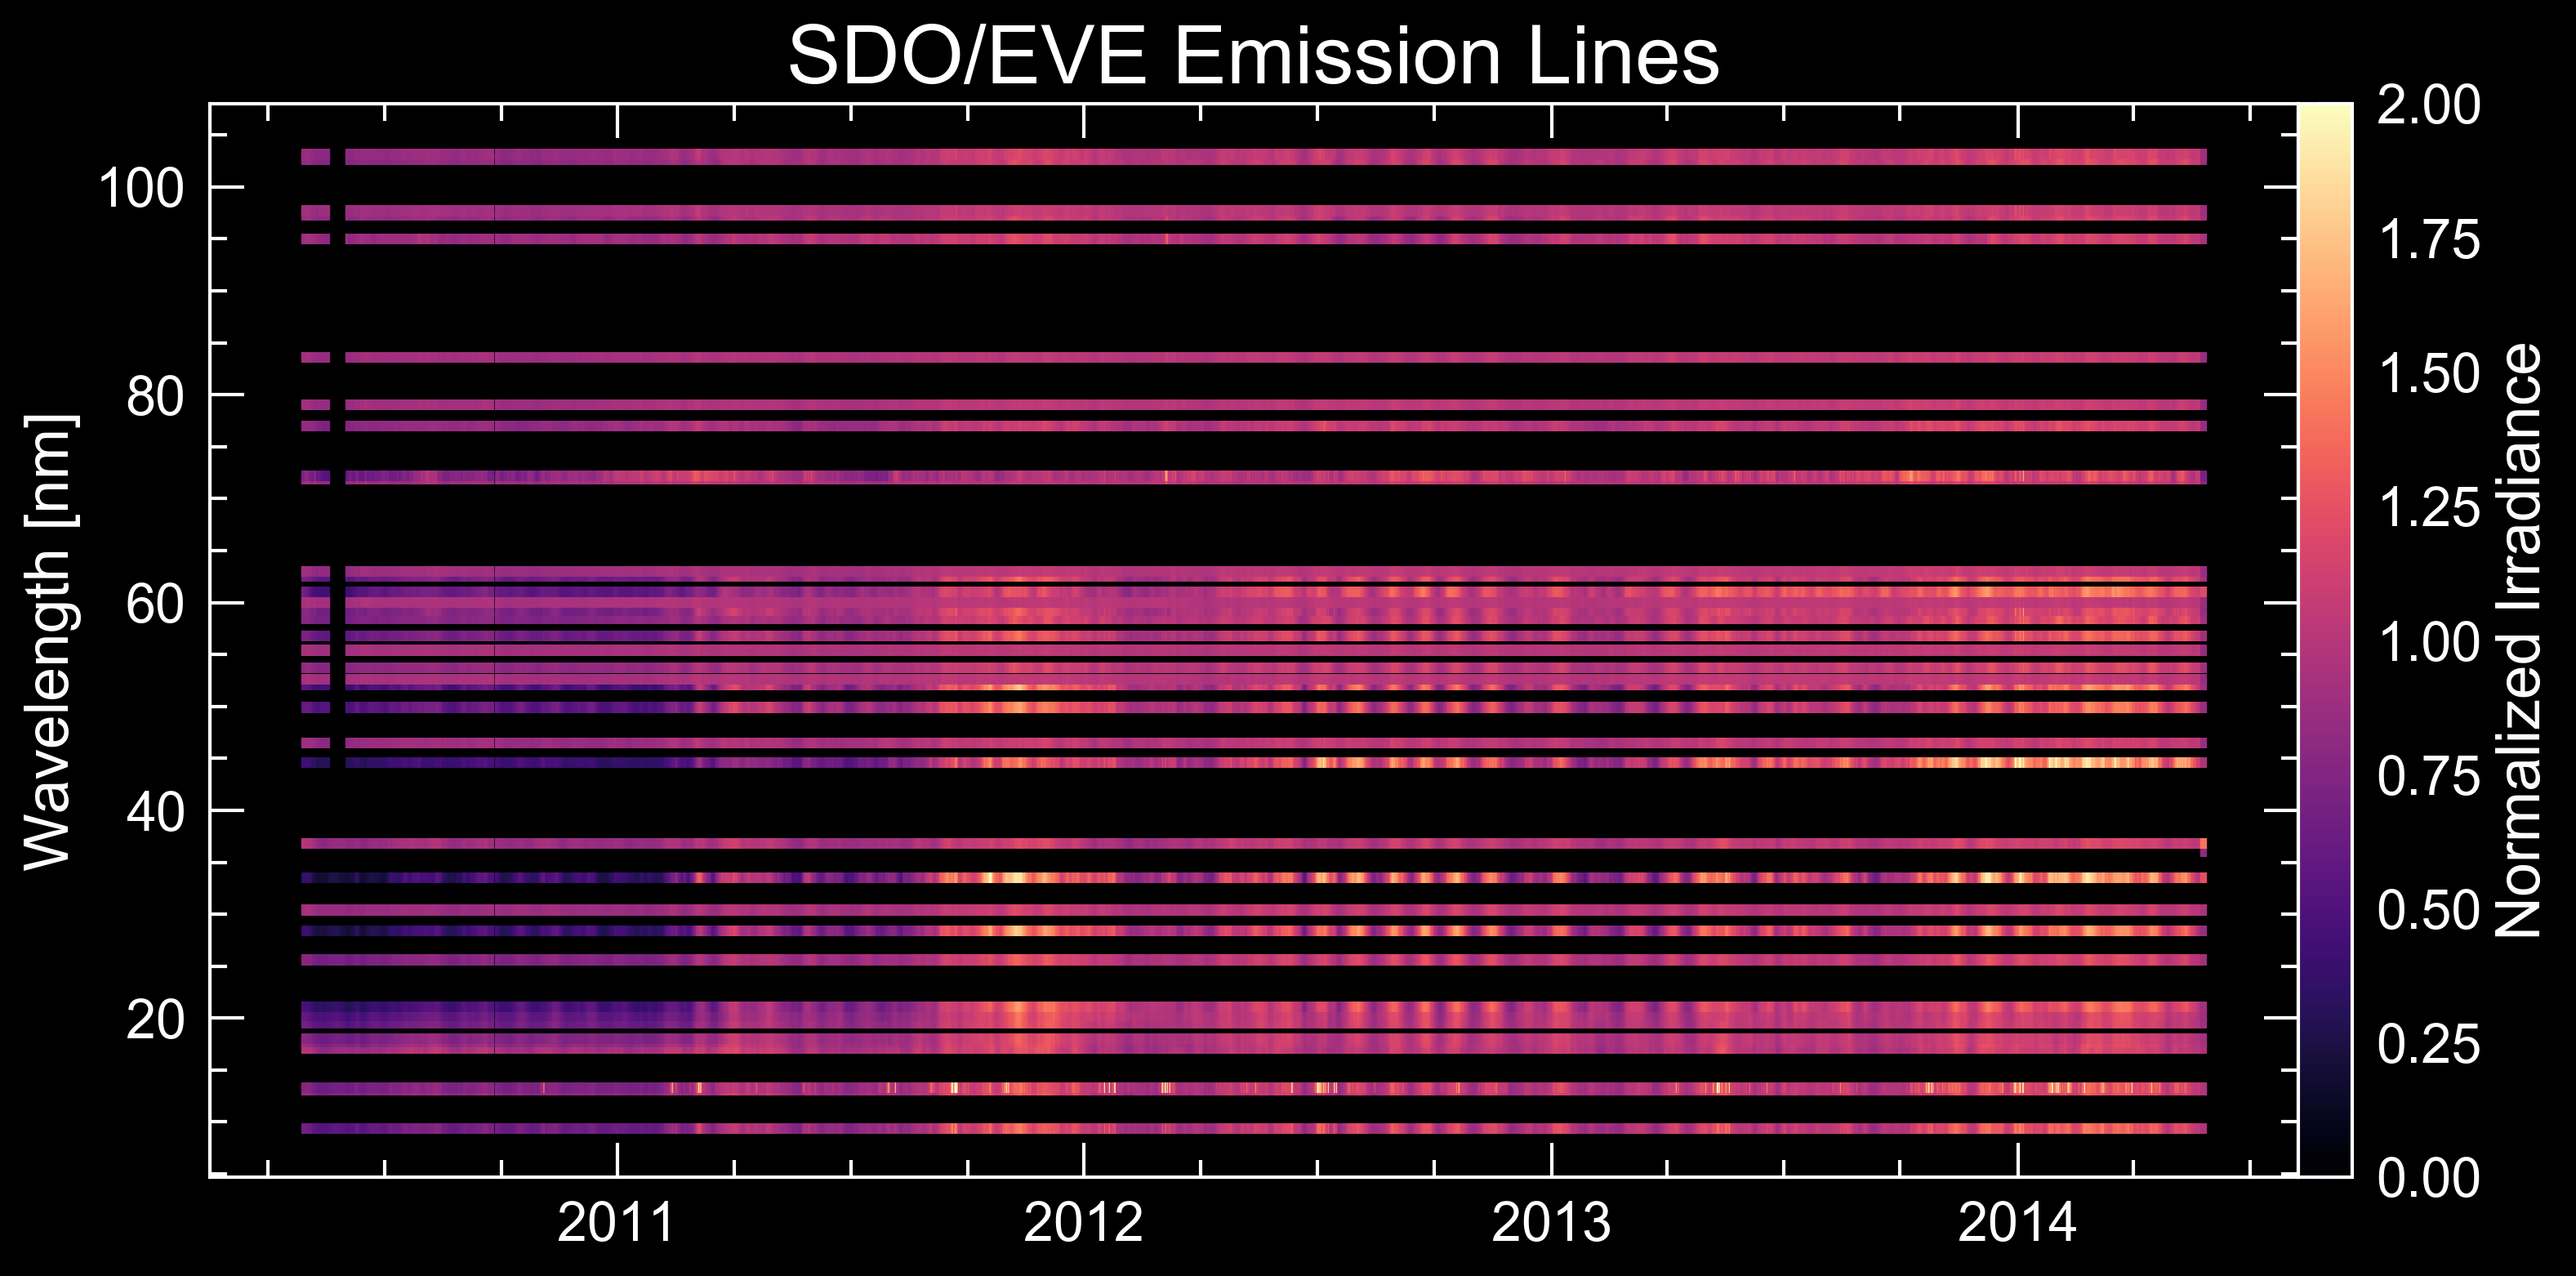

In [27]:
plt.style.use('jpm-transparent-dark')
plt.figure(dpi=300, figsize=(11, 6))
for wave_index in range(39):
    p = plt.scatter(time_subsampled, np.repeat(wavelength[wave_index], len(time_subsampled)), 
                    c=intensity_norm_subsampled[:, wave_index], 
                    cmap=plt.cm.magma, marker='|', s=10, edgecolor='none')
    plt.clim(0, 2)#np.nanmin(intensity_norm_subsampled), np.nanmax(intensity_norm_subsampled))
    
fig = plt.gcf()
ax = plt.gca()
fmtr = dates.DateFormatter("%Y")
ax.xaxis.set_major_formatter(fmtr)
ax.xaxis.set_major_locator(dates.YearLocator())
plt.ylabel('Wavelength [nm]')
plt.title('SDO/EVE Emission Lines')
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.73])
fig.colorbar(p, label='Normalized Irradiance', cax=cbar_ax)
plt.savefig('All EVE By Wavelength DarkBG.png')

## Make another plot with x = time, y = wavelength index, c = normalized irradiance

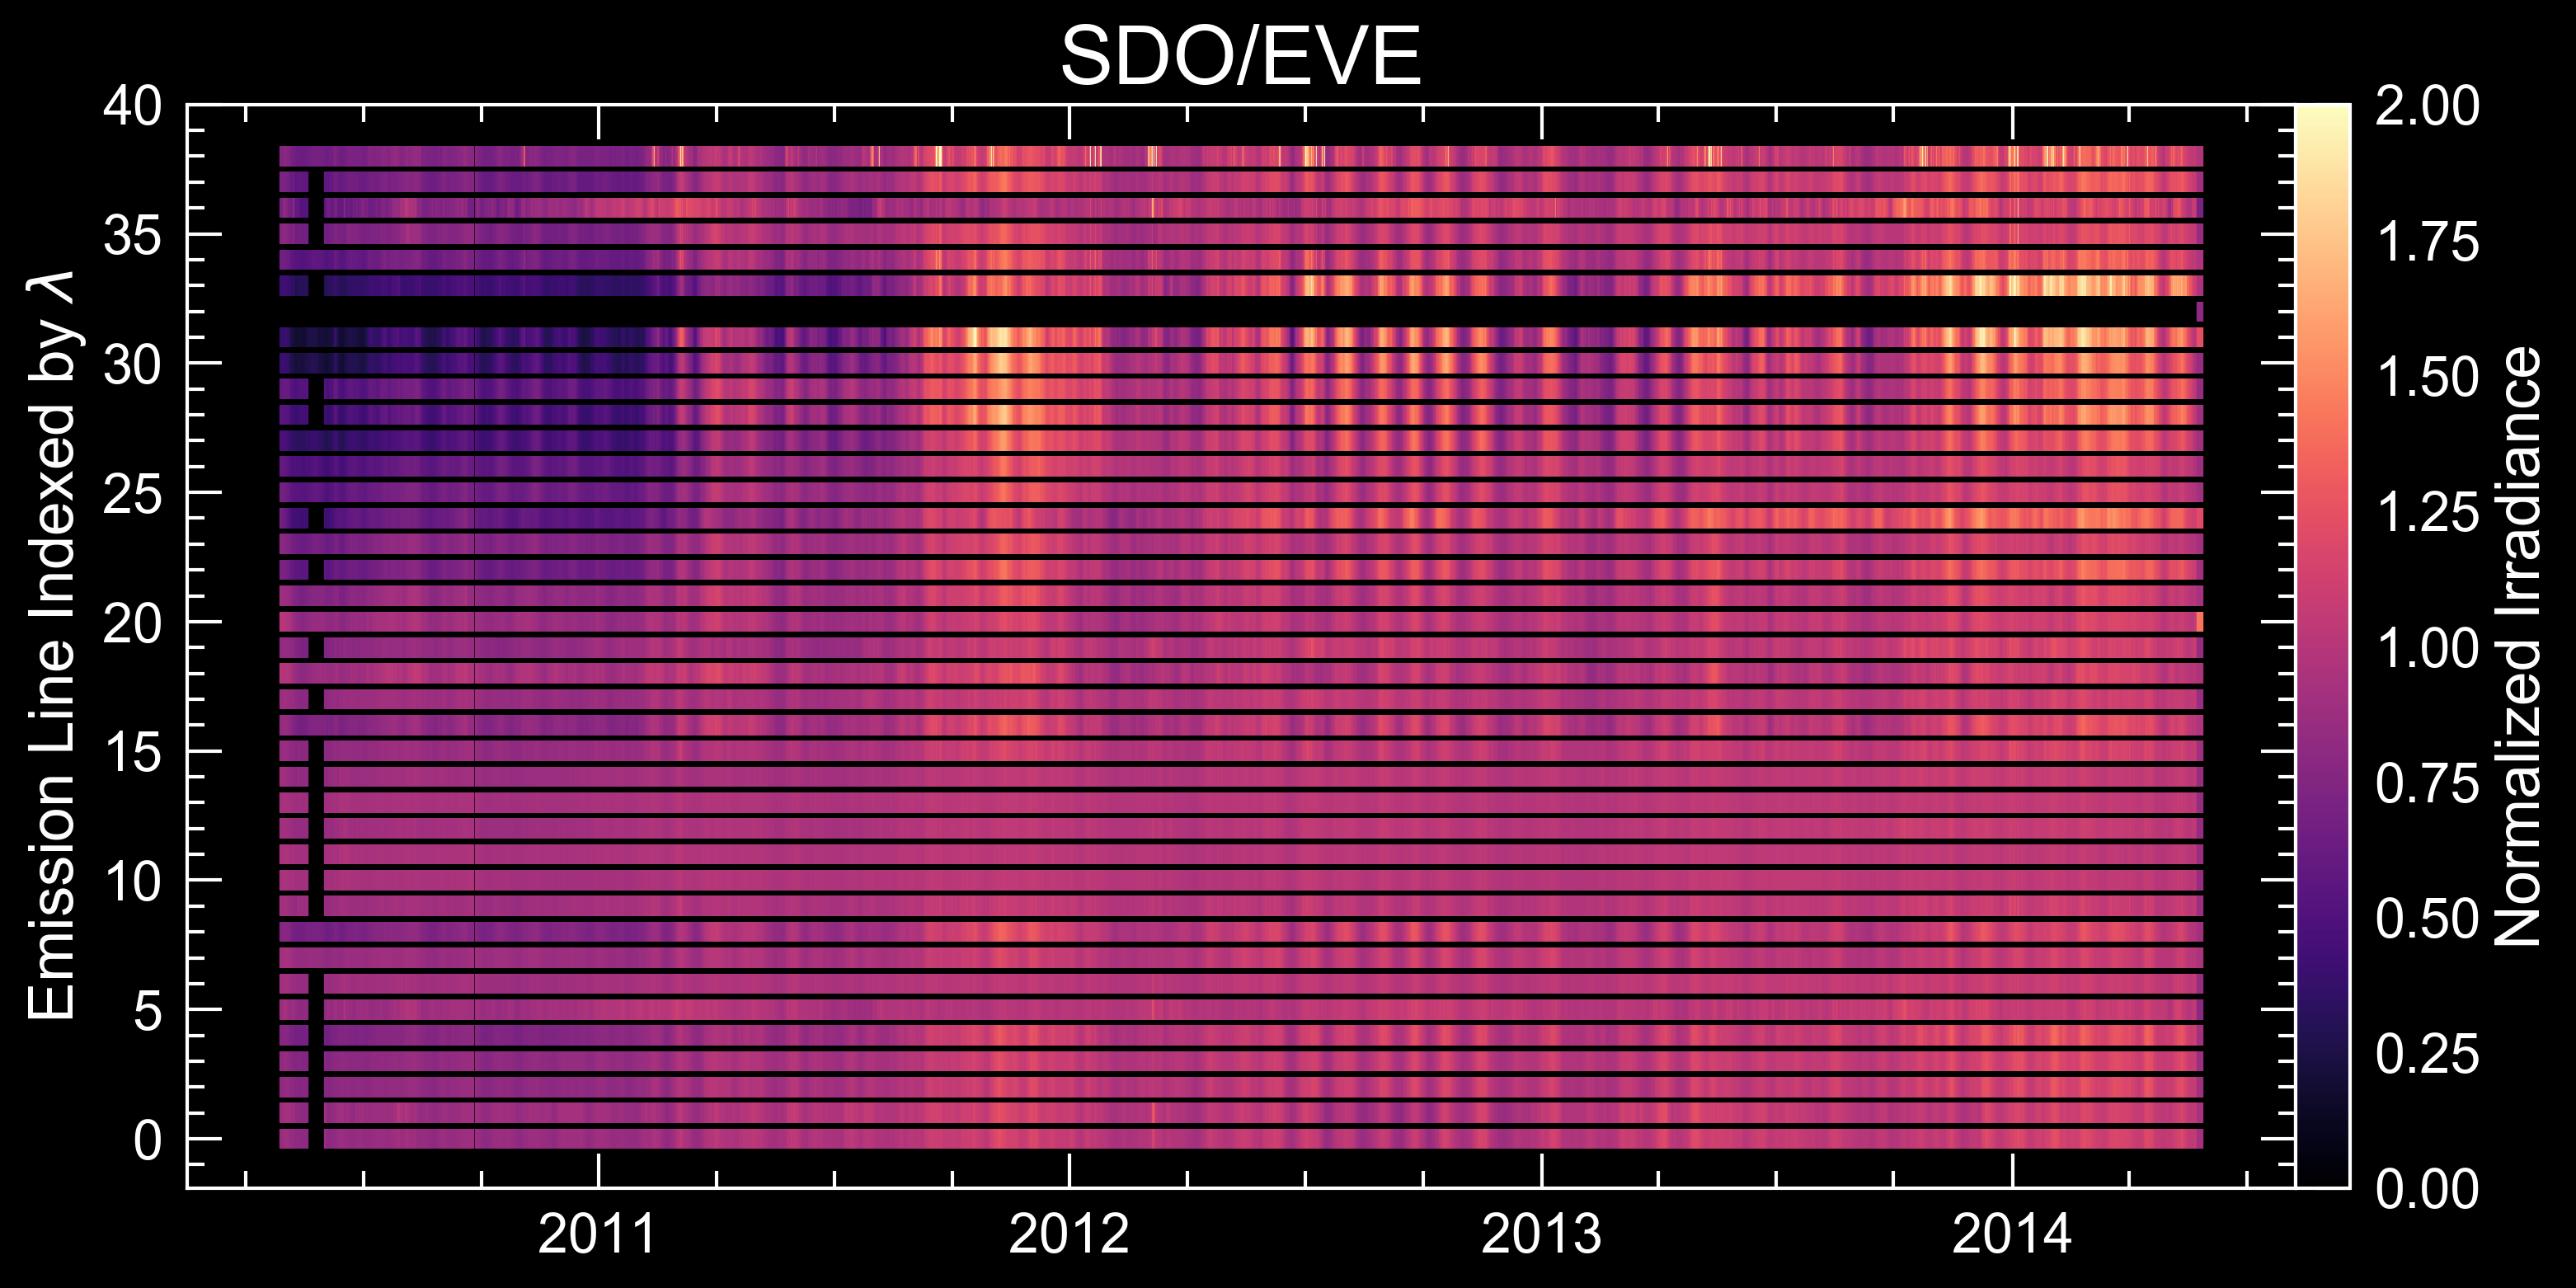

In [37]:
plt.style.use('jpm-transparent-dark')
plt.figure(dpi=300, figsize=(11, 6))
for wave_index in range(39):
    p = plt.scatter(time_subsampled, np.repeat(wave_index, len(time_subsampled)), 
                    c=intensity_norm_subsampled[:, wave_index], 
                    cmap=plt.cm.magma, marker='|', s=35, edgecolor='none')
    plt.clim(0, 2)#np.nanmax(intensity_norm_subsampled))
    
fig = plt.gcf()
ax = plt.gca()
fmtr = dates.DateFormatter("%Y")
ax.xaxis.set_major_formatter(fmtr)
ax.xaxis.set_major_locator(dates.YearLocator())
plt.ylabel('Emission Line Indexed by $\lambda$')
plt.title('SDO/EVE')
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.73])
fig.colorbar(p, label='Normalized Irradiance', cax=cbar_ax)
plt.savefig('All EVE By Wavelength Index DarkBG.png')

## Sort for temperature and produce plots

In [31]:
time = eve_lines_temperature_sorted_df.index
temperature = logt[sorted_temperature_indices]
intensity = eve_lines_temperature_sorted_df.values
intensity_norm = np.empty_like(intensity)
for i in range(39):
    intensity_norm[:, i] = intensity[:, i] / np.nanmedian(intensity[:, i])

In [32]:
# Smooth and subsample the data to dramatically decrease plotting time
# Can't see all 2 million points in time on the plot anyway
subsample = 1000
intensity_norm_subsampled = block_reduce(intensity_norm, block_size=(subsample, 1), func=np.nanmean)
time_subsampled = time[0:-1:subsample]

/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/skimage/measure/block.py:77: RuntimeWarning: Mean of empty slice
  out = func(out, axis=-1)


## Make another plot with x = time, y = temperature, color = normalized irradiance

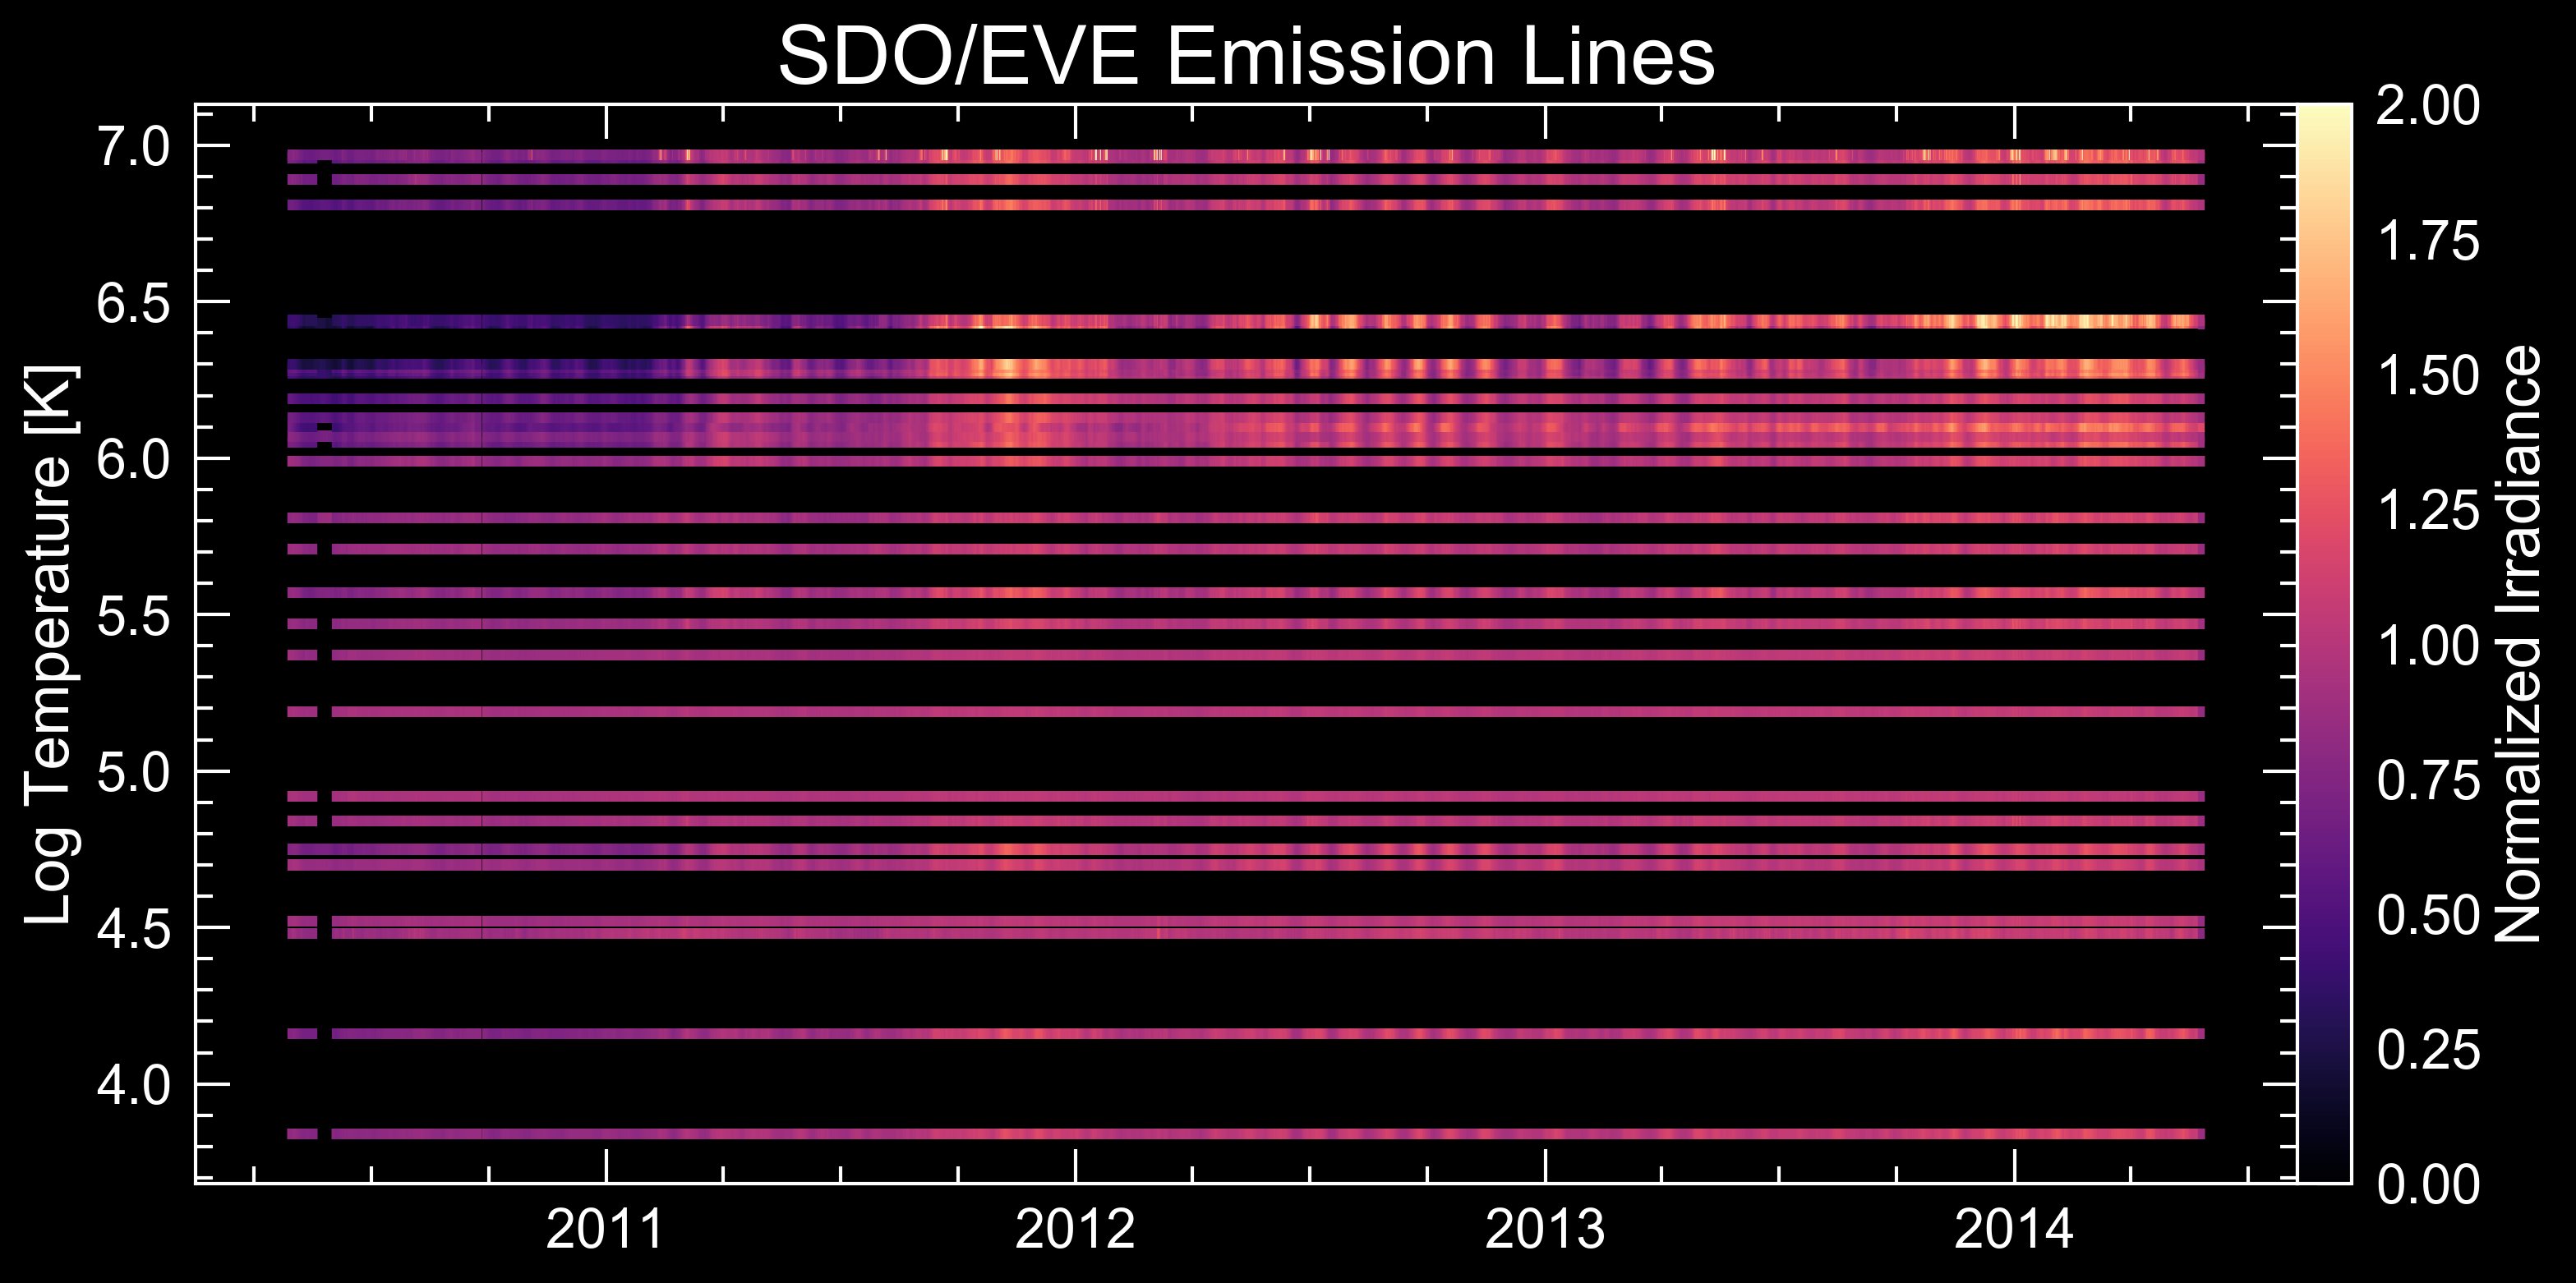

In [34]:
plt.style.use('jpm-transparent-dark')
plt.figure(dpi=300, figsize=(11, 6))
for wave_index in range(39):
    p = plt.scatter(time_subsampled, np.repeat(temperature[wave_index], len(time_subsampled)), 
                    c=intensity_norm_subsampled[:, wave_index], 
                    cmap=plt.cm.magma, marker='|', s=10, edgecolor='none')
    plt.clim(0, 2)#np.nanmin(intensity_norm_subsampled), np.nanmax(intensity_norm_subsampled))
    
fig = plt.gcf()
ax = plt.gca()
fmtr = dates.DateFormatter("%Y")
ax.xaxis.set_major_formatter(fmtr)
ax.xaxis.set_major_locator(dates.YearLocator())
plt.ylabel('Log Temperature [K]')
plt.title('SDO/EVE Emission Lines')
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.73])
fig.colorbar(p, label='Normalized Irradiance', cax=cbar_ax)
plt.savefig('All EVE By Temperature DarkBG.png')

## Make another plot with x = time, y = temperature index, color = normalized irradiance

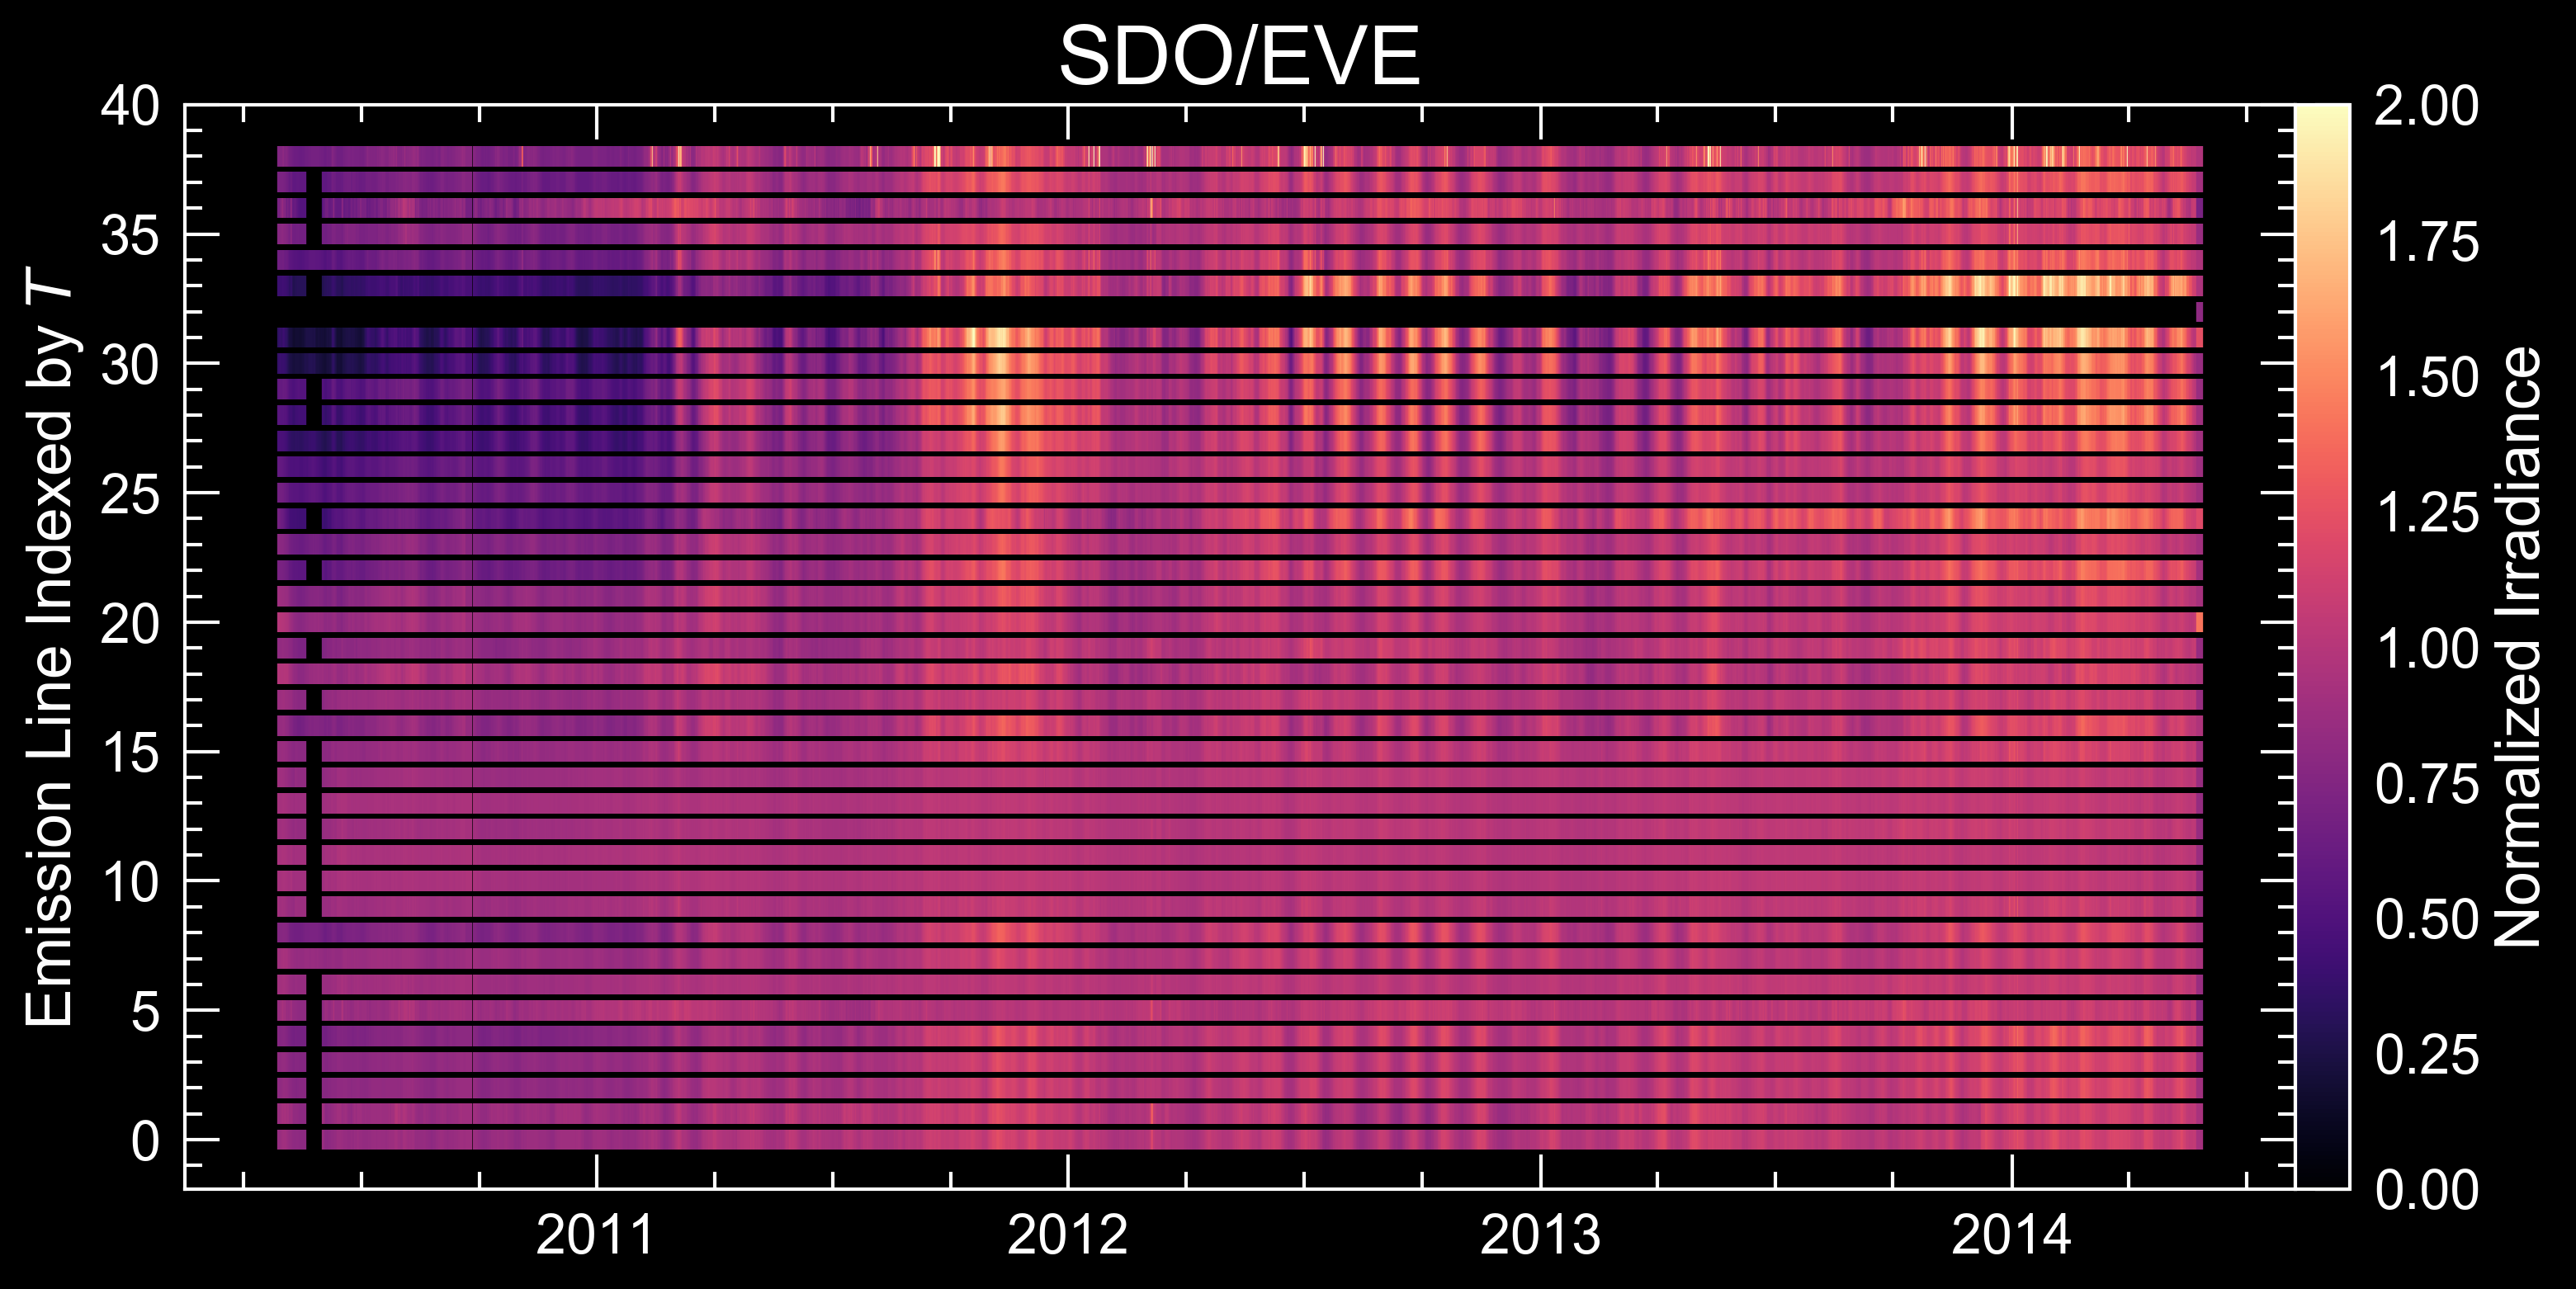

In [40]:
plt.style.use('jpm-transparent-dark')
plt.figure(dpi=300, figsize=(11, 6))
for wave_index in range(39):
    p = plt.scatter(time_subsampled, np.repeat(wave_index, len(time_subsampled)), 
                    c=intensity_norm_subsampled[:, wave_index], 
                    cmap=plt.cm.magma, marker='|', s=35, edgecolor='none')
    plt.clim(0, 2)#np.nanmin(intensity_norm_subsampled), np.nanmax(intensity_norm_subsampled))
    
fig = plt.gcf()
ax = plt.gca()
fmtr = dates.DateFormatter("%Y")
ax.xaxis.set_major_formatter(fmtr)
ax.xaxis.set_major_locator(dates.YearLocator())
plt.ylabel('Emission Line Indexed by $T$')
plt.title('SDO/EVE')
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.73])
fig.colorbar(p, label='Normalized Irradiance', cax=cbar_ax)
plt.savefig('All EVE By Temperature Index DarkBG.png')